In [15]:
"""
Contrastive + Reconstruction with an **internal 10 % hold‑out split**

•  Trains UNI2 + projection heads (InfoNCE) **and** a regressor that
   reconstructs Xenium‑5 k expression from the centre ViT embedding.
•  Cells are split 90 % / 10 % (stratified by pre‑computed Leiden clusters)
   before any optimisation.
•  After training, the script:
   – predicts expression on the unseen 10 % cells  
   – computes per‑gene Pearson R and R², saves them to CSV  
   – plots spatial scatter heatmaps (true vs. predicted) for marker genes
---------------------------------------------------------------------------
Adjust path strings, `marker_genes`, or `gene_dim` for your environment.
"""

# ---------------------------------------------------------------------
# 0. Imports
# ---------------------------------------------------------------------
import os, torch, timm, scanpy as sc
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd, numpy as np, openslide
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [7]:
# ---------------------------------------------------------------------
# 1. User params
# ---------------------------------------------------------------------
cancer = "lung"          # {lung, breast, …}
ground_truth = "refined"
mode = "train"
batch_size = 72
num_workers = 4
proj_dim = 128
gene_dim = 5001            # Xenium Prime 5 k panel
lr = 1e-4
epochs = 10
lambda_mse = 0.1             # weight on reconstruction loss
level = 0               # centre‑token level (0 or 1)
freeze_uni2 = False           # set True for baseline
ckpt_dir = f"/rsrch5/home/plm/phacosta/models/fine_tuned/gene_reconstruction/ckpts_contrastive_recon_{cancer}_ss"
marker_genes = [
    # ‑‑ T‑cell markers
    "CD3D", "CD3E", "CD4", "CD8A", "TRBC1",
    # ‑‑ B‑cell markers
    "MS4A1",   # a.k.a. CD20
    "CD79A",
    "CD19",
    # ‑‑ Macrophage / myeloid markers
    "CD68",
    "CD163",
    "LYZ",
    # ‑‑ Example tumor / proliferation / stroma markers 
    "TP53", "MKI67", "COL1A1"
]


In [8]:
# ---------------------------------------------------------------------
# 2. Paths
# ---------------------------------------------------------------------
xenium_sample_dict = {
    "lung":       "Xenium_Prime_Human_Lung_Cancer_FFPE_outs",
    "breast":     "Xenium_Prime_Breast_Cancer_FFPE_outs",
    "lymph_node": "Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs",
    "prostate":   "Xenium_Prime_Human_Prostate_FFPE_outs",
    "skin":       "Xenium_Prime_Human_Skin_FFPE_outs",
    "ovarian":    "Xenium_Prime_Ovarian_Cancer_FFPE_outs",
    "cervical":   "Xenium_Prime_Cervical_Cancer_FFPE_outs",
}
data_root   = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics"
embedding_root = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings"
xenium_sample  = xenium_sample_dict[cancer]

root = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics"
adata_path = f"{data_root}/{xenium_sample}/preprocessed/fine_tune_{ground_truth}_v2/processed_xenium_data_fine_tune_{ground_truth}_v2_annotated.h5ad"
emb_path = f"{embedding_root}/public_data/{xenium_sample}/scGPT_CP.h5ad"
slide_path = f"{data_root}/{xenium_sample}/{xenium_sample.rsplit('_',1)[0]}_he_image_registered.ome.tif" 

results_dir = f"/rsrch5/home/plm/phacosta/TIER2_Results/xenium_project/{xenium_sample}/"

os.makedirs(results_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# ---------------------------------------------------------------------
# 3. Load data
# ---------------------------------------------------------------------
adata = sc.read_h5ad(adata_path)
cell_df = adata.obs                       # index = cell IDs
gdata = sc.read_h5ad(emb_path)
gene_emb = pd.DataFrame(gdata.obsm["X_scGPT"], index=cell_df.index)  # (N,512)

slide = openslide.open_slide(slide_path)
mpp_x = float(slide.properties.get("openslide.comment").split('PhysicalSizeX="')[1].split('"')[0])
current_mpp= mpp_x
target_mpp = 0.5           # 20×
scale = target_mpp / current_mpp



# --------------------------------------------------------------------- #
# 4  Hold‑out split (stratified by existing Leiden clusters)
# --------------------------------------------------------------------- #
# If 'leiden' labels are missing, make them from the scGPT embeddings
if "leiden" not in cell_df.columns:
    print("No 'leiden' column found – running a quick clustering on scGPT space.")
    ad_tmp = sc.AnnData(
        gene_emb.values,              # (N_cells, 512)
        obs=pd.DataFrame(index=cell_df.index)
    )
    sc.pp.neighbors(ad_tmp, use_rep="X", n_neighbors=15)
    sc.tl.leiden(ad_tmp, resolution=0.5)
    cell_df["leiden"] = ad_tmp.obs["leiden"].astype(str).values
    print("Leiden clusters added:", cell_df["leiden"].unique())



train_idx, test_idx = train_test_split(
    np.arange(len(cell_df)),
    test_size=0.10,
    stratify=cell_df['leiden'],
    random_state=42
)
print("Train:", len(train_idx), "| Test:", len(test_idx))


No 'leiden' column found – running a quick clustering on scGPT space.
Leiden clusters added: ['2' '0' '4' '9' '1' '8' '12' '7' '3' '13' '10' '5' '11' '6' '14']
Train: 220193 | Test: 24466


In [9]:
# --------------------------------------------------------------------- #
# 5  Slide & transform
# --------------------------------------------------------------------- #
slide         = openslide.open_slide(slide_path)
mpp_x         = float(slide.properties.get("openslide.comment").split('PhysicalSizeX=\"')[1].split('\"')[0])
scale         = 0.5 / mpp_x             # 20× target MPP
patch_size    = 224
tfm = transforms.Compose([
    transforms.Resize((patch_size, patch_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406),
                         std =(0.229,0.224,0.225)),
])

class CellPatchDS(Dataset):
    def __init__(self, idx_array):
        self.cells = cell_df.iloc[idx_array].reset_index(drop=False)
    def __len__(self): return len(self.cells)
    def __getitem__(self, i):
        r = self.cells.iloc[i]
        big = int(patch_size * scale)
        tlx, tly = int(r.x_centroid - big/2), int(r.y_centroid - big/2)
        img = slide.read_region((tlx,tly),0,(big,big)).convert("RGB")
        img = img.resize((patch_size,patch_size), Image.LANCZOS)
        return tfm(img), r.name  # r.name == original row index (cell ID)

def make_loader(idxs, shuffle, bs):
    return DataLoader(
        CellPatchDS(idxs), batch_size=bs, shuffle=shuffle,
        num_workers=num_workers, pin_memory=True, persistent_workers=True)

test_loader  = make_loader(test_idx,  shuffle=False, bs=64)

Loaded checkpoint: /rsrch5/home/plm/phacosta/models/fine_tuned/gene_reconstruction/ckpts_contrastive_recon_lung_ss/best.pth


Predict: 100%|██████████| 383/383 [03:24<00:00,  1.87it/s]


Median Pearson R : 0.000666728
Median R²        : 1.869958845568398e-05
Skipping missing genes: LYZ, CD3D, TRBC1, COL1A1


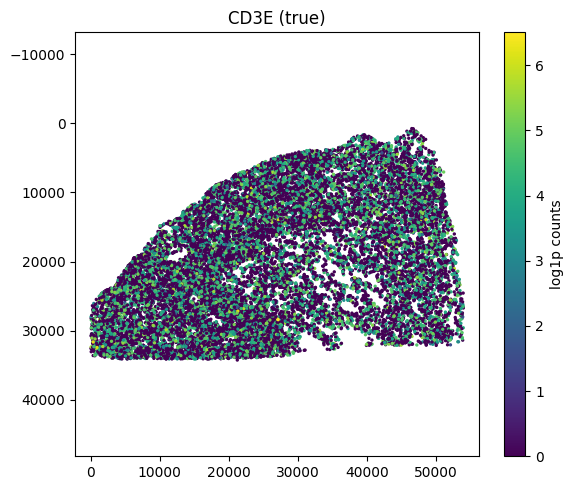

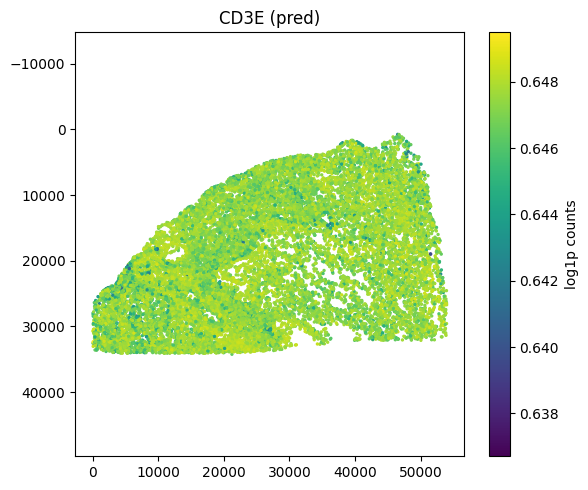

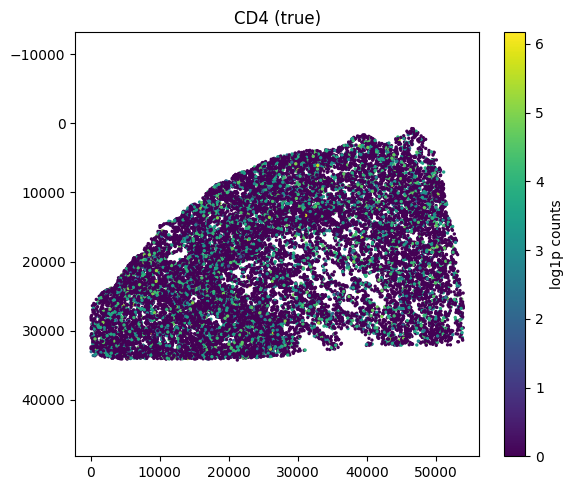

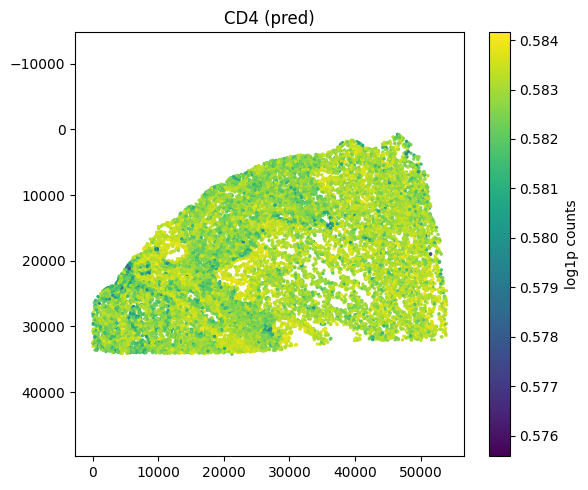

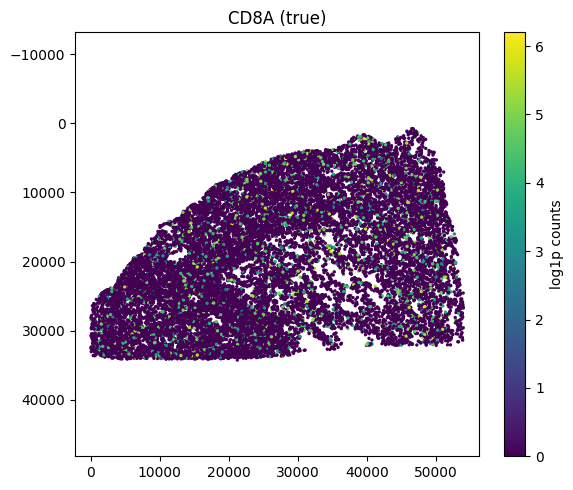

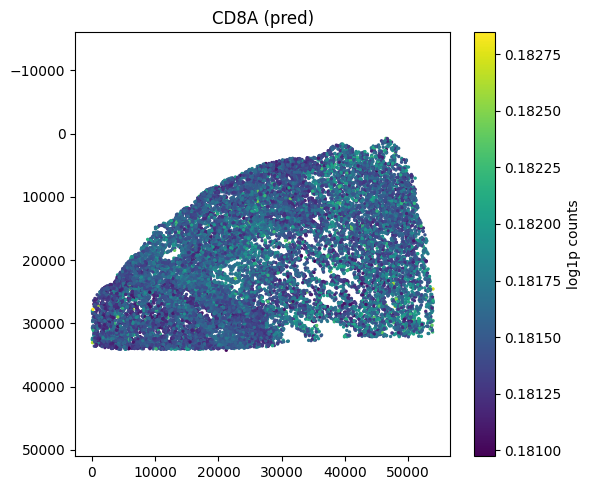

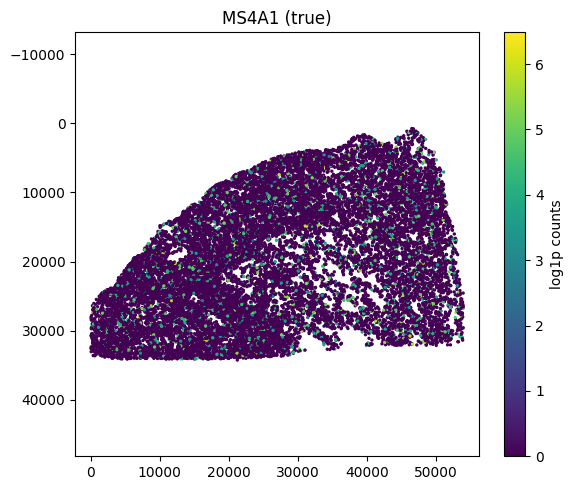

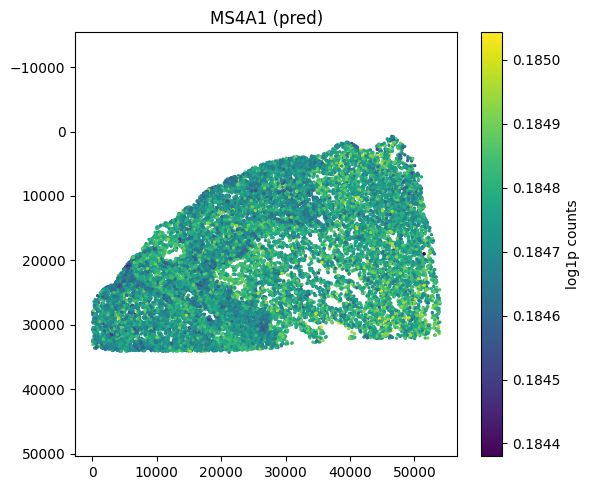

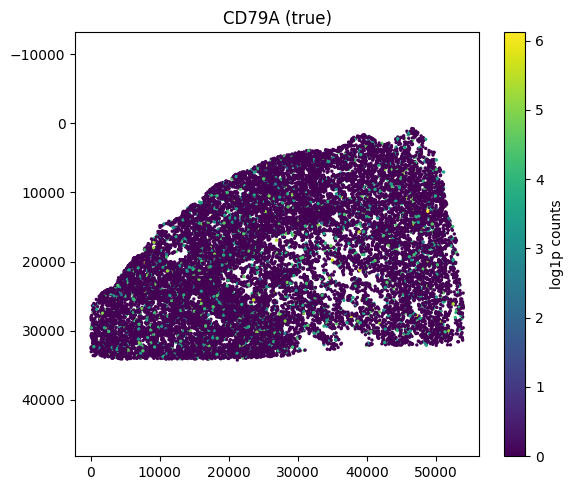

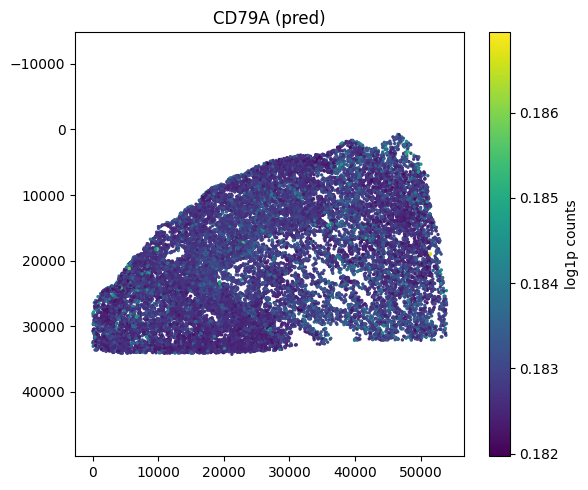

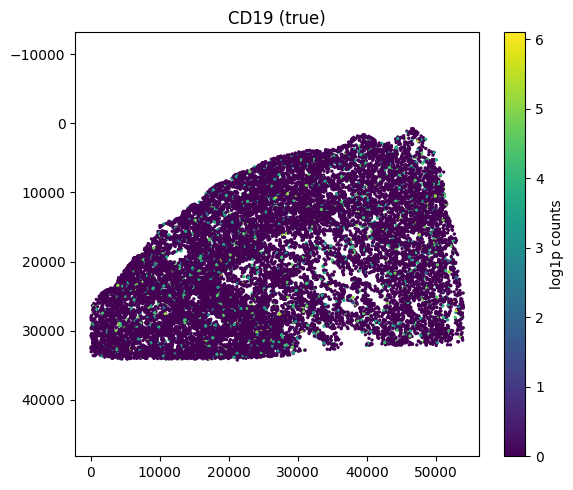

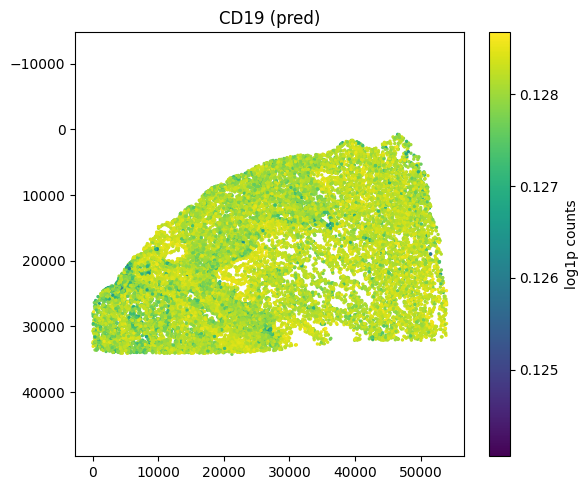

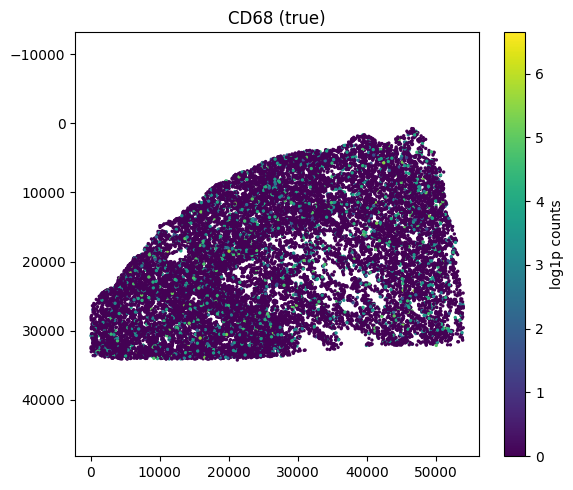

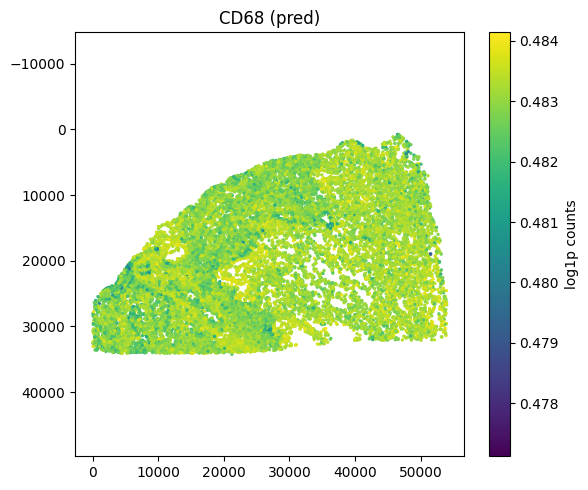

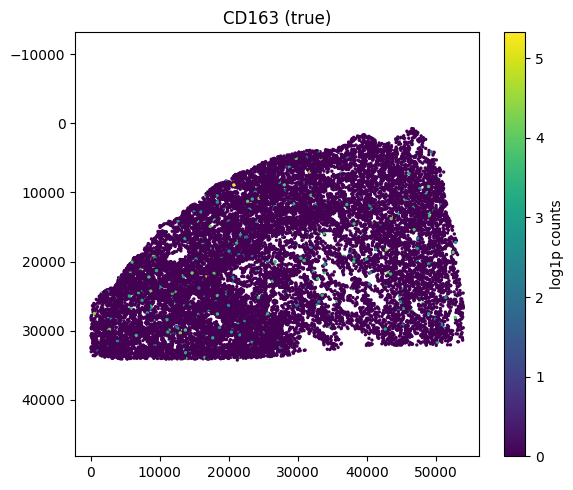

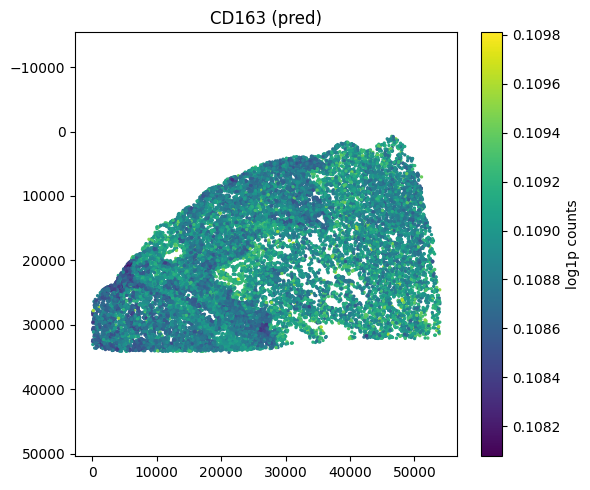

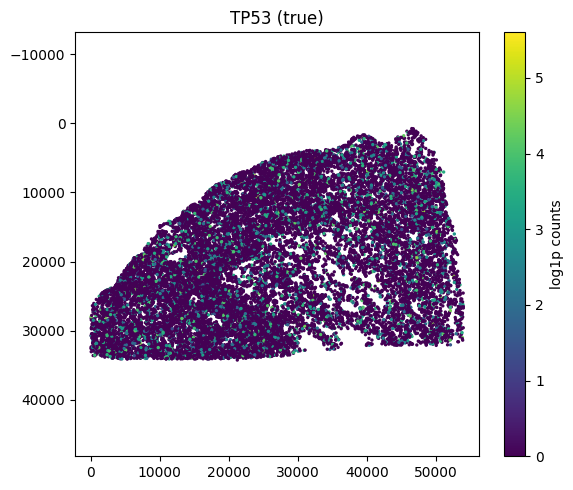

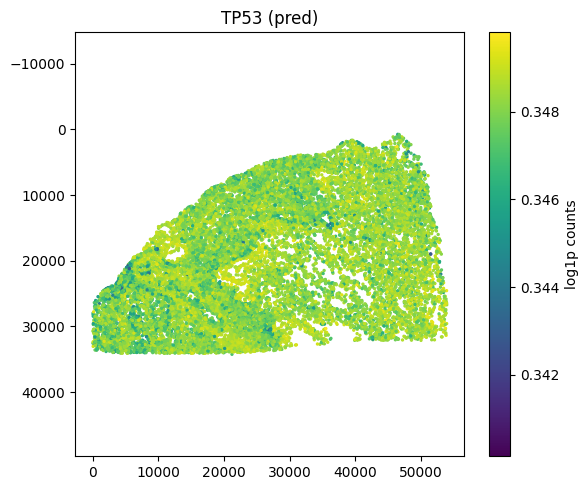

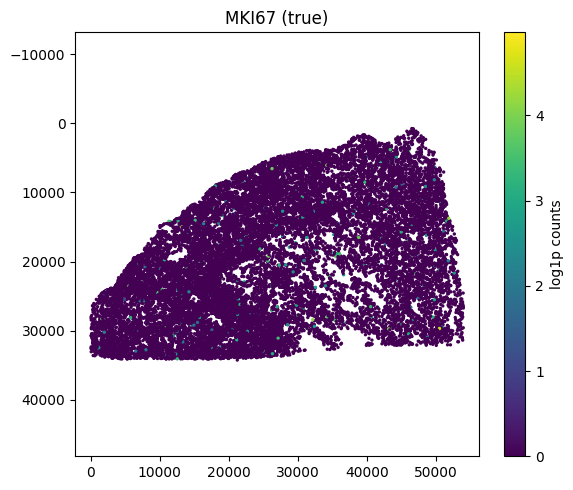

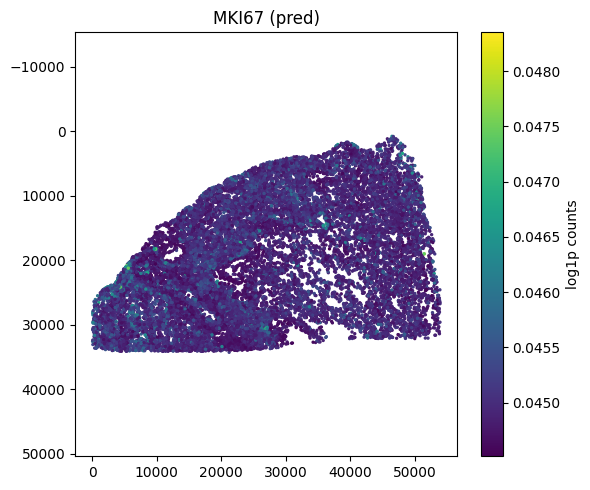

In [17]:
# ──────────────────────────────────────────────────────────────────────
# 6 Locate and load checkpoint
# ──────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

uni2_cfg = {
    'model_name':'vit_giant_patch14_224','img_size':224,'patch_size':14,'depth':24,
    'num_heads':24,'init_values':1e-5,'embed_dim':1536,'mlp_ratio':2.66667*2,
    'num_classes':0,'no_embed_class':True,'mlp_layer':timm.layers.SwiGLUPacked,
    'act_layer':torch.nn.SiLU,'reg_tokens':8,'dynamic_img_size':True
}
uni2_ckpt = "/rsrch5/home/plm/phacosta/models/public/UNI2-h/pytorch_model.bin"

model = timm.create_model(pretrained=False, **uni2_cfg).to(device)
model.load_state_dict(torch.load(uni2_ckpt, map_location="cpu"))

class Projection(nn.Module):
    def __init__(self, d_in, d_out): super().__init__()
    def forward(self,x): return x  # Not used during eval

proj_gene  = Projection(1,1)  # dummy
proj_morph = Projection(1,1)

reg_head   = nn.Sequential(
    nn.Linear(1536,512), nn.ReLU(), nn.Linear(512, gene_dim)
).to(device)


ckpt_path = (os.path.join(ckpt_dir,"best.pth")
             if os.path.exists(os.path.join(ckpt_dir,"best.pth"))
             else sorted(glob.glob(os.path.join(ckpt_dir,"epoch_*.pth")))[-1])

ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])
reg_head.load_state_dict(ckpt["reg_head"])
model.eval(); reg_head.eval()
print("Loaded checkpoint:", ckpt_path)

prefix_tokens = getattr(model, "num_prefix_tokens", 9)
level_idx = {
    0: torch.tensor([119,120,135,136], device=device),
    1: torch.tensor([102,103,104,105,118,119,120,121,
                     134,135,136,137,150,151,152,153], device=device)
}[level]

# ──────────────────────────────────────────────────────────────────────
# 6  Predict on hold‑out
# ──────────────────────────────────────────────────────────────────────
preds, truths, cell_ids = [], [], []
with torch.no_grad():
    for imgs, ids in tqdm(test_loader, desc="Predict"):
        imgs  = imgs.to(device)
        tok   = model.forward_features(imgs)
        center= tok[:, prefix_tokens:, :][:, level_idx, :].mean(1)
        preds.append(reg_head(center).cpu())
        truths.append(torch.as_tensor(
            adata.X[ids.numpy()].toarray(), dtype=torch.float32).cpu())
        cell_ids.extend(ids.numpy())

pred_mat = torch.cat(preds).numpy()
true_mat = torch.cat(truths).numpy()

# ──────────────────────────────────────────────────────────────────────
# 7  Per‑gene Pearson R & R²
# ──────────────────────────────────────────────────────────────────────
R, R2 = [], []
for g in range(gene_dim):
    if np.std(true_mat[:,g])==0:
        R.append(np.nan); R2.append(np.nan); continue
    r = pearsonr(true_mat[:,g], pred_mat[:,g])[0]
    R.append(r); R2.append(r**2)

pd.Series(R,  name="PearsonR").to_csv(os.path.join(results_dir, "per_gene_R.csv"))
pd.Series(R2, name="R2").to_csv(os.path.join(results_dir, "per_gene_R2.csv"))
print("Median Pearson R :", np.nanmedian(R))
print("Median R²        :", np.nanmedian(R2))


# ──────────────────────────────────────────────────────────────────────
# 8  Spatial plots for marker genes
# ──────────────────────────────────────────────────────────────────────
gene_to_idx = {g:i for i,g in enumerate(adata.var_names)}
test_cells  = cell_df.iloc[test_idx].copy()

# Create a subdirectory for plots if desired
plot_dir = os.path.join(results_dir, "gene_plots")
os.makedirs(plot_dir, exist_ok=True)

present = [g for g in marker_genes if g in gene_to_idx]
missing  = set(marker_genes) - set(present)
if missing:
    print("Skipping missing genes:", ", ".join(missing))

for g in present:
    gi = gene_to_idx[g]
    test_cells[f"{g}_true"] = true_mat[:, gi]
    test_cells[f"{g}_pred"] = pred_mat[:, gi]

    for kind in ["true", "pred"]:
        plt.figure(figsize=(6, 5))
        plt.scatter(
            test_cells['x_centroid'], test_cells['y_centroid'],
            c=test_cells[f"{g}_{kind}"], cmap="viridis", s=2
        )
        plt.gca().invert_yaxis()
        plt.axis('equal')
        plt.title(f"{g} ({kind})")
        plt.colorbar(label="log1p counts")
        plt.tight_layout()

        # Save the figure
        save_path = os.path.join(plot_dir, f"{g}_{kind}.png")
        plt.savefig(save_path, dpi=300)
        plt.show()
        plt.close()